In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers
from keras.layers import Dropout
from keras.regularizers import l2
import gc

2023-07-28 03:16:59.194165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 03:17:10.735195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# loading data set
df = pd.read_csv('../final_df/XAUUSD_M30_fdf.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()

# number of rows to use 
df = df[-50000:]
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [3]:
# scaling relevant features 

scaler = MinMaxScaler()

df[[
    'open', 'high', 'low', 'close', 'volume', 'ema_100', 'ema_200', 'vwap', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 
    'MACD_12_26_9',	'MACDs_12_26_9', 'MACDh_12_26_9', 'volume_change', 'volume_pct_change', 
    'open_change', 'high_change', 'low_change', 'close_change', 'open_pct_change', 'high_pct_change', 
    'low_pct_change', 'close_pct_change'
    ]] = scaler.fit_transform(df[[
                                    'open', 'high', 'low', 'close', 'volume', 'ema_100', 'ema_200', 'vwap', 'STOCHk_14_3_3',
                                    'STOCHd_14_3_3', 'MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9', 'volume_change', 'volume_pct_change',
                                    'open_change', 'high_change', 'low_change', 'close_change', 'open_pct_change', 'high_pct_change', 
                                    'low_pct_change', 'close_pct_change']])


In [4]:
df

,open,open_change,open_pct_change,high,high_change,high_pct_change,low,low_change,low_pct_change,close,...,STOCHk_14_3_3,STOCHd_14_3_3,MACD_12_26_9,MACDs_12_26_9,MACDh_12_26_9,ema_signal,vwap_signal,stochrsi_signal,macd_signal,trend
0,0.012304,0.596672,0.583712,0.013974,0.542653,0.513445,0.013845,0.810635,0.826475,0.014332,...,0.855708,0.688401,0.653634,0.636387,0.571951,1,1,0,1,1
1,0.014216,0.550324,0.521198,0.013962,0.528756,0.494787,0.013107,0.748386,0.737778,0.012257,...,0.886808,0.801479,0.659474,0.641572,0.574852,1,0,0,1,1
2,0.012269,0.514648,0.473432,0.012152,0.511523,0.471674,0.011515,0.741750,0.728356,0.011348,...,0.815578,0.853473,0.662076,0.646311,0.571299,1,-1,-1,1,1
3,0.011313,0.523810,0.485674,0.010794,0.515859,0.477467,0.010124,0.743318,0.730565,0.009794,...,0.681394,0.794507,0.661071,0.649875,0.561913,1,-1,0,1,1
4,0.009759,0.518280,0.478253,0.010036,0.521607,0.485177,0.010836,0.759655,0.753782,0.009844,...,0.607178,0.699916,0.659840,0.652445,0.553993,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.758654,0.549247,0.512125,0.754401,0.515859,0.483471,0.758111,0.753581,0.745410,0.757302,...,0.494461,0.436699,0.601249,0.597369,0.530989,-1,0,0,-1,0
49996,0.757290,0.520037,0.486425,0.755271,0.537205,0.502291,0.758356,0.756029,0.747692,0.759319,...,0.551734,0.506586,0.605435,0.598070,0.539080,0,1,0,1,1
49997,0.759330,0.551510,0.514114,0.756018,0.536016,0.501239,0.760328,0.769447,0.760196,0.759132,...,0.563355,0.532606,0.608522,0.599334,0.543561,0,0,0,1,1
49998,0.759124,0.530740,0.495838,0.756447,0.532981,0.498562,0.760553,0.755875,0.747546,0.759544,...,0.616561,0.573909,0.611679,0.601062,0.547272,0,0,0,1,1


In [5]:
# inititalizing empty arrays
o0 = []
o1 = []
o2 = []
h0 = []
h1 = []
h2 = []
l0 = []
l1 = []
l2 = []
c0 = []
c1 = []
c2 = []
v0 = []
v1 = []
v2 = []
em1 = []
em2 = []
vw = []
stk= []
std = []
ma = []
ms = []
mh = []
em_s = []
vw_s = []
st_s = []
ma_s = []
y = []

In [6]:
for i in range(0, df.shape[0] - 230):
    o0.append(np.array(df.iloc[i:i+230, 0]))
    o1.append(np.array(df.iloc[i:i+230, 1]))
    o2.append(np.array(df.iloc[i:i+230, 2]))
    h0.append(np.array(df.iloc[i:i+230, 3]))
    h1.append(np.array(df.iloc[i:i+230, 4]))
    h2.append(np.array(df.iloc[i:i+230, 5]))
    l0.append(np.array(df.iloc[i:i+230, 6]))
    l1.append(np.array(df.iloc[i:i+230, 7]))
    l2.append(np.array(df.iloc[i:i+230, 8]))
    c0.append(np.array(df.iloc[i:i+230, 9]))
    c1.append(np.array(df.iloc[i:i+230, 10]))
    c2.append(np.array(df.iloc[i:i+230, 11]))
    v0.append(np.array(df.iloc[i:i+230, 12]))
    v1.append(np.array(df.iloc[i:i+230, 13]))
    v2.append(np.array(df.iloc[i:i+230, 14]))
    em1.append(np.array(df.iloc[i:i+230, 15]))
    em2.append(np.array(df.iloc[i:i+230, 16]))
    vw.append(np.array(df.iloc[i:i+230, 17]))
    stk.append(np.array(df.iloc[i:i+230, 18]))
    std.append(np.array(df.iloc[i:i+230, 19]))
    ma.append(np.array(df.iloc[i:i+230, 20]))
    ms.append(np.array(df.iloc[i:i+230, 21]))
    mh.append(np.array(df.iloc[i:i+230, 22]))
    em_s.append(np.array(df.iloc[i:i+230, 23]))
    vw_s.append(np.array(df.iloc[i:i+230, 24]))
    st_s.append(np.array(df.iloc[i:i+230, 25]))
    ma_s.append(np.array(df.iloc[i:i+230, 26]))

    y.append(np.array(df.iloc[i+230, 27]))

In [7]:
y = np.reshape(y, (len(y), 1))
y.shape

(49770, 1)

In [8]:
X= []
X = np.stack([o0, o1, o2, h0, h1, h2, l0, l1, l2, c0, c1, c2, v0, v1, v2, em1, em2, vw, stk, std, ma ,ms, mh, em_s, vw_s, st_s, ma_s], axis=2)

In [9]:
del o1
del h0
del o0
del h2
del o2
del l1
del h1
del c0
del l0
del c2 
del l2
del v0 
del c1
del v1 
del v2 
del em1 
del em2
del vw 
del stk
del std 
del ma 
del ms 
del mh 
del em_s 
del vw_s
del st_s
del ma_s 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [11]:
del X
gc.collect()

0

In [12]:
model = Sequential()

# Model
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(128, activation='tanh'))
model.add(Dense(1))

# Compile the model with appropriate optimizer, loss function and metrics
optimizers.SGD(momentum=0.9)
model.compile(optimizer='SGD', loss='mse', metrics=['mae'])

model.summary()

2023-07-28 03:19:24.379188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-28 03:19:25.687710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-28 03:19:25.688314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 230, 128)          79872     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 228097 (891.00 KB)
Trainable params: 228097 (891.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2, restore_best_weights=True)

In [14]:
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=6, callbacks=[early_stopping])


2023-07-28 03:19:33.531446: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 791203680 exceeds 10% of free system memory.
2023-07-28 03:19:33.823312: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 791203680 exceeds 10% of free system memory.


Epoch 1/20


2023-07-28 03:19:37.018734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-07-28 03:19:37.416450: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8046758ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-28 03:19:37.416489: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-07-28 03:19:37.438971: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment var

5309/5309 [==============================] - 111s 20ms/step - loss: 0.2274 - mae: 0.3746 - val_loss: 0.2130 - val_mae: 0.3651
Epoch 2/20
5309/5309 [==============================] - 110s 21ms/step - loss: 0.2088 - mae: 0.3614 - val_loss: 0.2105 - val_mae: 0.3648
Epoch 3/20
5309/5309 [==============================] - 111s 21ms/step - loss: 0.2061 - mae: 0.3592 - val_loss: 0.2102 - val_mae: 0.3634
Epoch 4/20
5309/5309 [==============================] - 108s 20ms/step - loss: 0.2047 - mae: 0.3577 - val_loss: 0.2061 - val_mae: 0.3601
Epoch 5/20
5309/5309 [==============================] - 111s 21ms/step - loss: 0.2033 - mae: 0.3567 - val_loss: 0.2055 - val_mae: 0.3582
Epoch 6/20
5309/5309 [==============================] - 111s 21ms/step - loss: 0.2019 - mae: 0.3551 - val_loss: 0.2036 - val_mae: 0.3574
Epoch 7/20
5309/5309 [==============================] - 111s 21ms/step - loss: 0.2006 - mae: 0.3544 - val_loss: 0.2030 - val_mae: 0.3565
Epoch 8/20
5309/5309 [==============================

In [15]:
model.save('XAUUSD-old.hdf5')

/media/gxz/DATA/Test_Projects/ezm_30/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model = keras.models.load_model('main-tanh-(128, 128, 128)-sgd-period7_(1kk).hdf5')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [25]:
predictions = model.predict(X_test)
cmp = [1 if x > 0.9 else -1 if x < -0.9 else 0 for x in predictions]

312/312 [==============================] - 3s 8ms/step


In [26]:
def get_result():
    acc = 0
    cnt = 0
    for i in range(len(cmp)):
        if (cmp[i] == 1 and y_test[i] == 1) or (cmp[i] == -1 and y_test[i] == -1) or (cmp[i] == 0 and y_test[i] == 0):
            acc += 1
        cnt += 1
    print(acc, cnt)
    acc = 0
    cnt = 0
    for i in range(len(cmp)):
        if (cmp[i] == 1 and y_test[i] == 1) or (cmp[i] == -1 and y_test[i] == -1):
            acc += 1
        cnt += 1
    print(acc, cnt)
    acc = 0
    cnt = 0
    for i in range(len(cmp)):
        if (cmp[i] == 1 and y_test[i] != 1) or (cmp[i] == -1 and y_test[i] != -1):
            acc += 1
        cnt += 1
    print(acc, cnt)

get_result()

6280 9954
450 9954
20 9954


In [ ]:
# XAUUSD
# Thrsh|  Accuracy |    Wins   |   Losses  |  W:L 
# 0.50 | 7360 9954 | 2210 9954 |  716 9954 |  3:1
# 0.60 | 7219 9954 | 1723 9954 |  364 9954 |  5:1
# 0.70 | 6922 9954 | 1234 9954 |  167 9954 |  7:1
# 0.80 | 6590 9954 |  798 9954 |   58 9954 | 13:1
# 0.90 | 6280 9954 |  450 9954 |   20 9954 | 22:1

<function matplotlib.pyplot.show(close=None, block=None)>

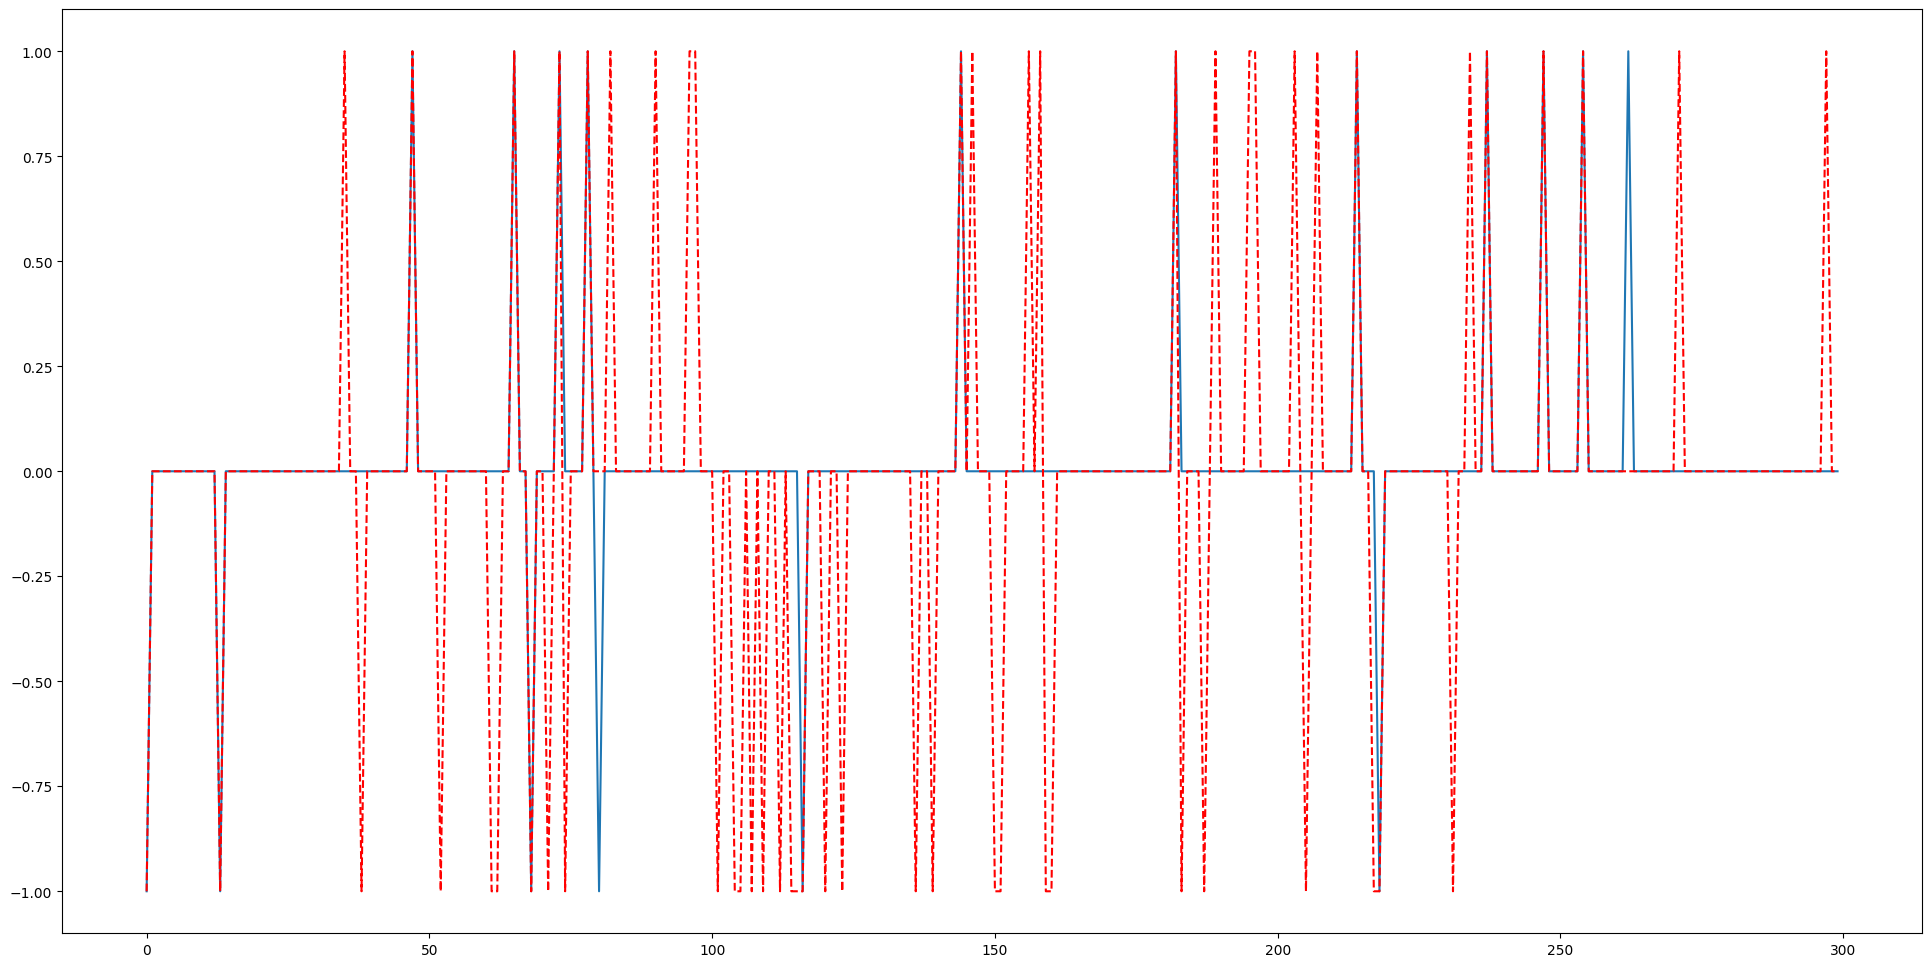

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.plot(cmp[-500:-200])
plt.plot(y_test[-500:-200],'r', linestyle='--' )
plt.show